In [1]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv('lineages_with_amp.csv', index_col=0)

In [6]:
df.head()

,organism_name,taxid,species_taxid,superkingdom,phylum,class,order,family,genus,species,biotype,num_AMP
0,Shigella flexneri,623,623,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Shigella,Shigella flexneri,NaN,30.0
1,Shigella dysenteriae,622,622,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Shigella,Shigella dysenteriae,NaN,35.0
2,Shigella sp. FC2531,1898681,1898681,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Shigella,Shigella sp. FC2531,NaN,27.0
3,Shigella sp. FC1056,1892898,1892898,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Shigella,Shigella sp. FC1056,NaN,28.0
4,Shigella boydii,621,621,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Shigella,Shigella boydii,NaN,28.0


# Getting info from log files
Because Jared didn't think to put it somewhere more useful

In [103]:
import re
import os

In [50]:
def extract_from_single_file(filepath):
    # VIA CLAUDE
    # Define regular expressions
    filepath_pattern = r'(/projects/.+\.gz)$'
    positive_pattern = r'num positive for AMP = (\d+)\.'
    total_pattern = r'Total sequences processed = (\d+)'
    rate_pattern = r'AMP detection rate with threshold of 0.99 = (\d+\.\d+)'

    # Initialize lists to store data
    filepaths = []
    positives = []
    totals = []
    rates = []

    # Open the file and read the contents
    with open(filepath, 'r') as f:
        contents = f.read()

    # Split the contents by the string "processing file at"
    parts = re.split(r'processing file at', contents)

    # Iterate over each part
    for part in parts:
        if 'processing for file already completed, skipping....' in part:
            continue  # Skip this part

        # Extract the filepath
        match = re.search(filepath_pattern, part, re.MULTILINE)
        if match:
            filepath = match.group(1)
            filepaths.append(filepath)
        else:
            filepaths.append(None)

        # Extract the number of positive sequences
        match = re.search(positive_pattern, part, re.MULTILINE)
        if match:
            positive = int(match.group(1))
            positives.append(positive)
        else:
            positives.append(None)

        # Extract the total number of sequences processed
        match = re.search(total_pattern, part, re.MULTILINE)
        if match:
            total = int(match.group(1))
            totals.append(total)
        else:
            totals.append(None)

        # Extract the AMP detection rate
        match = re.search(rate_pattern, part, re.MULTILINE)
        if match:
            rate = float(match.group(1))
            rates.append(rate)
        else:
            rates.append(None)

    # Create a pandas dataframe
    data = {'filepath': filepaths, 'num_AMPs': positives, 'num_sequences': totals, '%amp': rates}
    df = pd.DataFrame(data)

    # Print the dataframe
    return df

In [56]:
jobs = os.listdir('outputs')
output_df = pd.DataFrame()
for job in jobs:
    df = extract_from_single_file('outputs/'+job)
    output_df = pd.concat([output_df, df])

In [67]:
console_output_results = output_df.dropna()
console_output_results.head(2)

,filepath,num_AMPs,num_sequences,%amp
2,/projects/greengenes2/gg2_genomes/ncbi/GCF/902...,36.0,866.0,0.041570
3,/projects/greengenes2/gg2_genomes/ncbi/GCF/902...,11.0,658.0,0.016717


In [68]:
lineages_df = pd.read_csv('lineages_with_amp.csv', index_col=0).drop(['species', 'biotype'], axis=1)
lineages_df.head(2)

,organism_name,taxid,species_taxid,superkingdom,phylum,class,order,family,genus,num_AMP
0,Shigella flexneri,623,623,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Shigella,30.0
1,Shigella dysenteriae,622,622,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Shigella,35.0


In [69]:
refseq_paths = pd.read_csv('refseq_paths.csv')
refseq_paths.head(2)

,organism_name,taxid,species_taxid,ftp_path
0,Shigella flexneri,623,623,/projects/greengenes2/gg2_genomes/ncbi/GCF/002...
1,Shigella dysenteriae,622,622,/projects/greengenes2/gg2_genomes/ncbi/GCF/002...


In [71]:
console_with_taxid = console_output_results.merge(refseq_paths, how='inner', left_on='filepath', right_on='ftp_path')

In [78]:
console_with_taxid = console_with_taxid.drop(['filepath', 'organism_name', 'species_taxid'], axis=1)

In [84]:
final_df = lineages_df.merge(console_with_taxid, on='taxid').drop('num_AMPs', axis=1)

In [86]:
final_df.to_csv('more_results.csv')

In [88]:
final_df.head()

,organism_name,taxid,species_taxid,superkingdom,phylum,class,order,family,genus,num_AMP,num_sequences,%amp,ftp_path
0,Mobilicoccus massiliensis,1522310,1522310,Bacteria,Actinomycetota,Actinomycetes,Micrococcales,Dermatophilaceae,Mobilicoccus,36.0,866.0,0.041570,/projects/greengenes2/gg2_genomes/ncbi/GCF/902...
1,Streptococcus agalactiae,1311,1311,Bacteria,Bacillota,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,11.0,658.0,0.016717,/projects/greengenes2/gg2_genomes/ncbi/GCF/902...
2,Moellerella wisconsensis,158849,158849,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Morganellaceae,Moellerella,19.0,938.0,0.020256,/projects/greengenes2/gg2_genomes/ncbi/GCF/902...
3,Lentilactobacillus kefiri,33962,33962,Bacteria,Bacillota,Bacilli,Lactobacillales,Lactobacillaceae,Lentilactobacillus,18.0,790.0,0.022785,/projects/greengenes2/gg2_genomes/ncbi/GCF/902...
4,Lactonifactor longoviformis,341220,341220,Bacteria,Bacillota,Clostridia,Eubacteriales,Clostridiaceae,Lactonifactor,63.0,1321.0,0.047691,/projects/greengenes2/gg2_genomes/ncbi/GCF/902...


# Exploratory Data Analysis

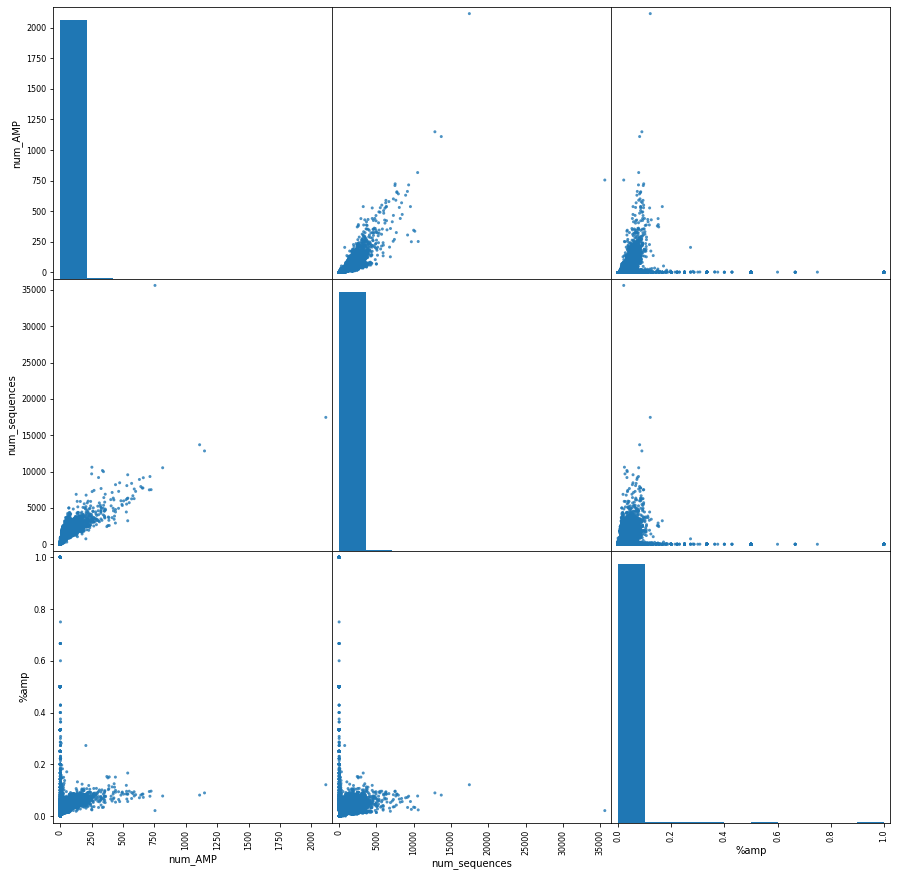

In [92]:
grr = pd.plotting.scatter_matrix(final_df[['num_AMP', 'num_sequences', '%amp']], figsize=(15,15), alpha=0.8)

In [95]:
final_df.sort_values(by='num_AMP', ascending=False)

,organism_name,taxid,species_taxid,superkingdom,phylum,class,order,family,genus,num_AMP,num_sequences,%amp,ftp_path
3268,Triticum dicoccoides,85692,85692,Eukaryota,Streptophyta,Magnoliopsida,Poales,Poaceae,Triticum,2114.0,17458.0,0.121091,/projects/greengenes2/gg2_genomes/ncbi/GCF/002...
45933,Emiliania huxleyi CCMP1516,280463,2903,Eukaryota,Haptophyta,NaN,Isochrysidales,Noelaerhabdaceae,Emiliania,1149.0,12841.0,0.089479,/projects/greengenes2/gg2_genomes/ncbi/GCF/000...
46002,Salvia splendens,180675,180675,Eukaryota,Streptophyta,Magnoliopsida,Lamiales,Lamiaceae,Salvia,1110.0,13693.0,0.081063,/projects/greengenes2/gg2_genomes/ncbi/GCF/004...
39488,Arabidopsis thaliana,3702,3702,Eukaryota,Streptophyta,Magnoliopsida,Brassicales,Brassicaceae,Arabidopsis,816.0,10527.0,0.077515,/projects/greengenes2/gg2_genomes/ncbi/GCF/000...
23858,Trichomonas vaginalis G3,412133,5722,Eukaryota,Parabasalia,NaN,Trichomonadida,Trichomonadidae,Trichomonas,755.0,35609.0,0.021203,/projects/greengenes2/gg2_genomes/ncbi/GCF/026...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34244,Pseudomonas phage 119X,2911431,347326,Viruses,Uroviricota,Caudoviricetes,NaN,Fredfastierviridae,Jamesmcgillvirus,0.0,33.0,0.000000,/projects/greengenes2/gg2_genomes/ncbi/GCF/000...
34246,Lily mottle virus,32624,32624,Viruses,Pisuviricota,Stelpaviricetes,Patatavirales,Potyviridae,Potyvirus,0.0,1.0,0.000000,/projects/greengenes2/gg2_genomes/ncbi/GCF/000...
7495,Grapevine virus A,35288,35288,Viruses,Kitrinoviricota,Alsuviricetes,Tymovirales,Betaflexiviridae,Vitivirus,0.0,3.0,0.000000,/projects/greengenes2/gg2_genomes/ncbi/GCF/000...
7496,Orthohantavirus tulaense,3052503,3052503,Viruses,Negarnaviricota,Ellioviricetes,Bunyavirales,Hantaviridae,Orthohantavirus,0.0,1.0,0.000000,/projects/greengenes2/gg2_genomes/ncbi/GCF/000...


In [101]:
final_df.drop(['taxid', 'species_taxid'], axis=1).groupby('superkingdom').describe().T

superkingdom             Archaea      Bacteria     Eukaryota      Viruses
num_AMP       count  1077.000000  46665.000000    762.000000  9599.000000
              mean     30.107707     41.840094    161.576115     0.687467
              std      11.327644     23.316971    151.800712     2.637951
              min       4.000000      0.000000      4.000000     0.000000
              25%      23.000000     26.000000     82.000000     0.000000
              50%      29.000000     37.000000    124.000000     0.000000
              75%      36.000000     52.000000    186.000000     1.000000
              max      99.000000    406.000000   2114.000000   205.000000
num_sequences count  1077.000000  46665.000000    762.000000  9599.000000
              mean   1202.792943   1352.092960   2534.135171    42.088447
              std     389.545552    561.284490   2216.232499    56.702041
              min     231.000000     32.000000     72.000000     1.000000
              25%     909.000000    962.000000   1348.000000     2.000000
              50%    1210.000000   1286.000000   2058.000000    29.000000
              75%    1476.000000   1676.000000   2971.750000    58.000000
              max    3495.000000   7250.000000  35609.000000   752.000000
%amp          count  1077.000000  46665.000000    762.000000  9599.000000
              mean      0.025861      0.030777      0.062613     0.028307
              std       0.008657      0.010066      0.019522     0.107739
              min       0.008065      0.000000      0.018626     0.000000
              25%       0.019928      0.023557      0.048711     0.000000
              50%       0.024155      0.029630      0.061016     0.000000
              75%       0.030146      0.037559      0.073887     0.016949
              max       0.090909      0.157895      0.166306     1.000000

Who is that 205 AMP virus?

In [102]:
final_df[final_df['num_AMP'] == 205]

,organism_name,taxid,species_taxid,superkingdom,phylum,class,order,family,genus,num_AMP,num_sequences,%amp,ftp_path
39836,Aspergillus heteromorphus CBS 117.55,1448321,51019,Eukaryota,Ascomycota,Eurotiomycetes,Eurotiales,Aspergillaceae,Aspergillus,205.0,2565.0,0.079922,/projects/greengenes2/gg2_genomes/ncbi/GCF/003...
44133,Chaetura pelagica,8897,8897,Eukaryota,Chordata,Aves,Apodiformes,Apodidae,Chaetura,205.0,2404.0,0.085275,/projects/greengenes2/gg2_genomes/ncbi/GCF/000...
48189,Pandoravirus inopinatum,1605721,1605721,Viruses,NaN,NaN,NaN,NaN,Pandoravirus,205.0,752.0,0.272606,/projects/greengenes2/gg2_genomes/ncbi/GCF/000...


Pandoravirus inopinatum!